Dataset: Standardized turbine data
Custom NN Parameters: Layers: [4, 10, 5, 1], Epochs: 1000, Learning Rate: 0.001, Momentum: 0.05
Custom NN MAPE: 1241.5810085478222
MLR-F MAPE: 191.38916457712088
BP-F MAPE: 183.2911938563285


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


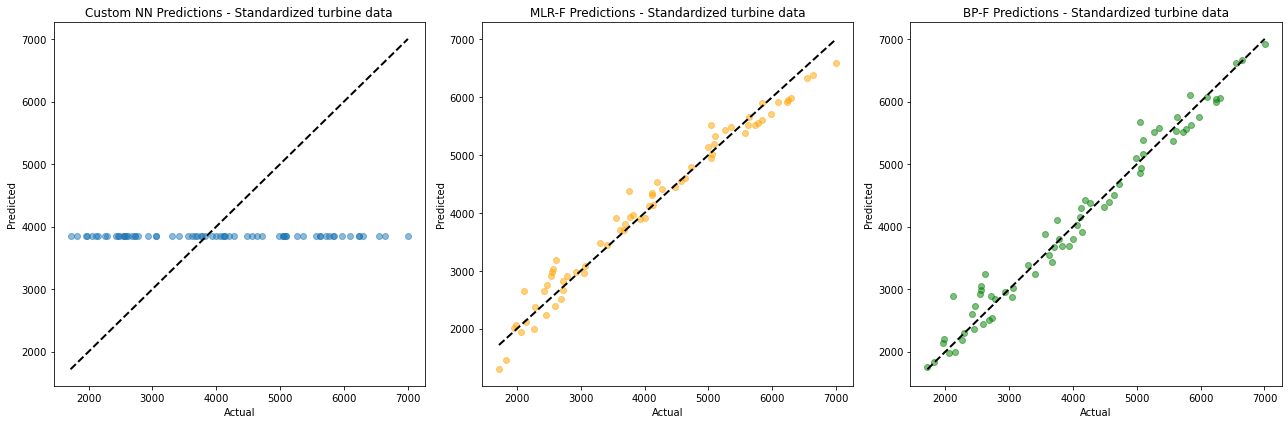

Dataset: Standardized synthetic data
Custom NN Parameters: Layers: [9, 10, 5, 1], Epochs: 1000, Learning Rate: 0.001, Momentum: 0.05
Custom NN MAPE: 0.5368603784168338
MLR-F MAPE: 0.5100958208570772
BP-F MAPE: 0.5468140740519558


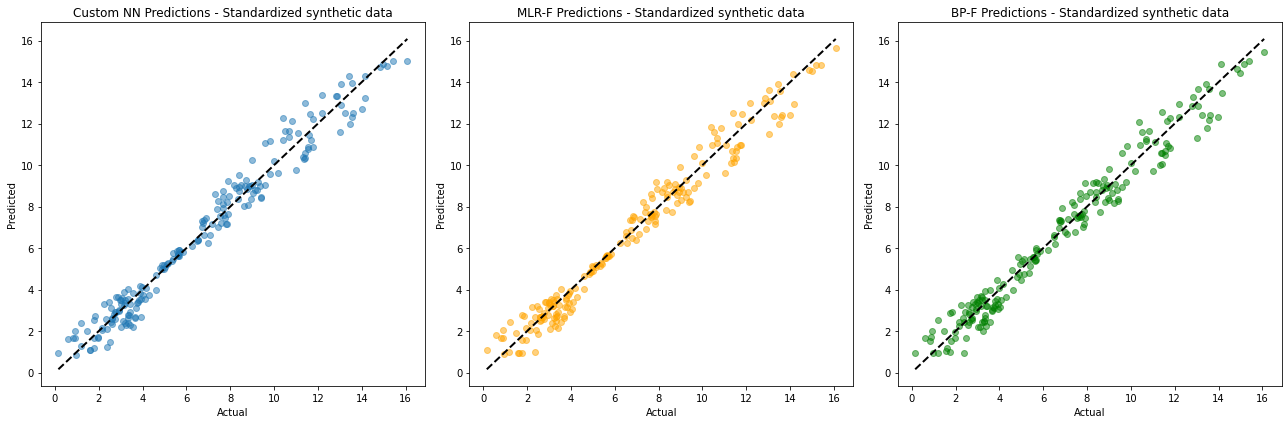

Dataset: Standardized boston housing data
Custom NN Parameters: Layers: [13, 10, 5, 1], Epochs: 1000, Learning Rate: 0.001, Momentum: 0.05
Custom NN MAPE: 2.3514364640737813
MLR-F MAPE: 2.4090158164834685
BP-F MAPE: 2.1475699531016716


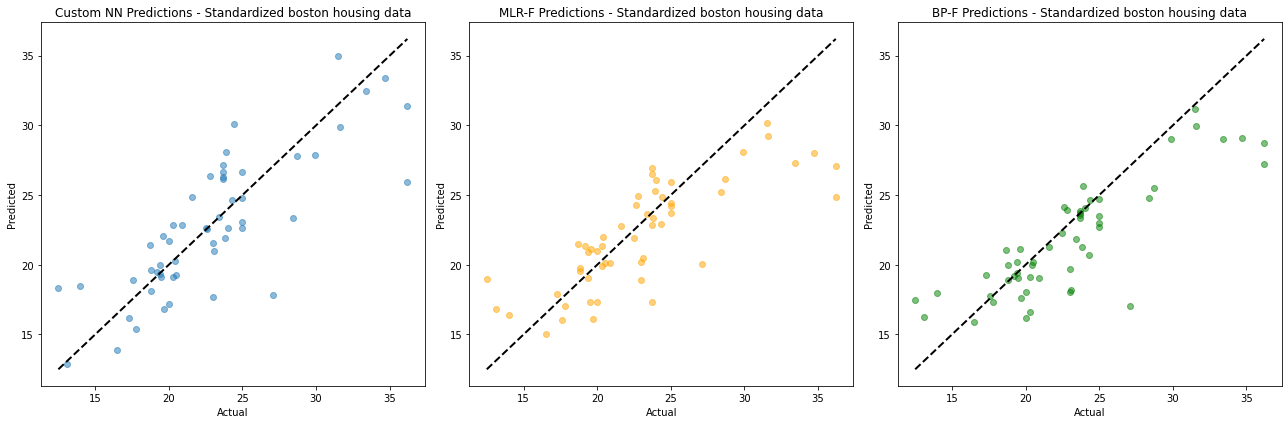

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

class MyNeuralNetwork:
    def __init__(self, num_layers, units_per_layer, num_epochs, learning_rate, momentum, validation_split):
        self.L = num_layers
        self.n = units_per_layer
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.validation_split = validation_split

        self.w = [np.random.randn(self.n[l - 1], self.n[l]) * np.sqrt(2 / self.n[l - 1]) for l in range(1, self.L)]
        self.theta = [np.zeros((self.n[l], 1)) for l in range(1, self.L)]

        self.d_w_prev = [np.zeros_like(w) for w in self.w]
        self.d_theta_prev = [np.zeros_like(theta) for theta in self.theta]

    def _forward_pass(self, x):
        x = x.reshape(-1, 1)
        activations = [x]
        for l in range(self.L - 1):
            z = np.dot(self.w[l].T, activations[l]) + self.theta[l]
            a = relu(z) if l < self.L - 2 else linear(z)
            activations.append(a)
        return activations

    def _backward_pass(self, activations, y):
        y = y.reshape(-1, 1)
        deltas = [(activations[-1] - y) * linear_derivative(activations[-1])]
        for l in range(self.L - 2, 0, -1):
            delta = np.dot(self.w[l], deltas[-1]) * relu_derivative(activations[l])
            deltas.append(delta)
        deltas.reverse()

        for l in range(self.L - 1):
            self.w[l] -= self.learning_rate * np.dot(activations[l], deltas[l].T) + self.momentum * self.d_w_prev[l]
            self.theta[l] -= self.learning_rate * np.sum(deltas[l], axis=1, keepdims=True) + self.momentum * self.d_theta_prev[l]
            self.d_w_prev[l] = self.learning_rate * np.dot(activations[l], deltas[l].T)
            self.d_theta_prev[l] = self.learning_rate * np.sum(deltas[l], axis=1, keepdims=True)

    def fit(self, X, y):
        split_at = int(X.shape[0] * (1 - self.validation_split))
        X_train, X_val = X[:split_at], X[split_at:]
        y_train, y_val = y[:split_at], y[split_at:]

        for epoch in range(self.num_epochs):
            for x_sample, y_sample in zip(X_train, y_train):
                activations = self._forward_pass(x_sample)
                self._backward_pass(activations, y_sample)

    def predict(self, X):
        predictions = np.array([self._forward_pass(x)[-1] for x in X])
        return predictions.squeeze()

    def loss_epochs(self):
        """Return the training and validation error for each epoch."""
        return np.array(self.training_errors), np.array(self.validation_errors)

    def _compute_loss(self, X, y):
        """Compute mean squared error loss."""
        predictions = self.predict(X)
        return np.mean((y - predictions) ** 2)

def load_and_split_data(url, test_size):
    df = pd.read_csv(url)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return train_test_split(X, y, test_size=test_size, random_state=42)

def extract_name_from_url(url):
    name = url.split('/')[-1]
    name = name.replace('_', ' ').replace('.csv', '')
    return name.capitalize()

def plot_predictions(actual, nn_predictions, mlr_predictions, bp_predictions, title):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.scatter(actual, nn_predictions, alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
    plt.title(f'Custom NN Predictions - {title}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.subplot(1, 3, 2)
    plt.scatter(actual, mlr_predictions, alpha=0.5, color='orange')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
    plt.title(f'MLR-F Predictions - {title}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.subplot(1, 3, 3)
    plt.scatter(actual, bp_predictions, alpha=0.5, color='green')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
    plt.title(f'BP-F Predictions - {title}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.tight_layout()
    plt.show()

dataset_urls = [
    "https://raw.githubusercontent.com/raccamateo/NEC_A1/main/standardized_turbine_data.csv",
    "https://raw.githubusercontent.com/raccamateo/NEC_A1/main/standardized_synthetic_data.csv",
    "https://raw.githubusercontent.com/raccamateo/NEC_A1/main/standardized_boston_housing_data.csv"
]
test_split_ratios = [0.15, 0.20, 0.20]

datasets = [load_and_split_data(url, test_size) for url, test_size in zip(dataset_urls, test_split_ratios)]

for url, (X_train, X_test, y_train, y_test), test_size in zip(dataset_urls, datasets, test_split_ratios):
    nn_layers = [X_train.shape[1], 10, 5, 1]
    custom_nn = MyNeuralNetwork(num_layers=len(nn_layers), units_per_layer=nn_layers, num_epochs=1000, learning_rate=0.001, momentum=0.05, validation_split=test_size)
    custom_nn.fit(X_train, y_train)
    custom_nn_predictions = custom_nn.predict(X_test)

    mlr_model = LinearRegression()
    mlr_model.fit(X_train, y_train)
    mlr_predictions = mlr_model.predict(X_test)

    bp_f_model = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=1000, learning_rate_init=0.01)
    bp_f_model.fit(X_train, y_train)
    bp_f_predictions = bp_f_model.predict(X_test)

    custom_nn_mape = mean_absolute_error(y_test, custom_nn_predictions)
    mlr_mape = mean_absolute_error(y_test, mlr_predictions)
    bp_f_mape = mean_absolute_error(y_test, bp_f_predictions)

    dataset_name = extract_name_from_url(url)
    print(f"Dataset: {dataset_name}")
    print("Custom NN Parameters: Layers: {}, Epochs: {}, Learning Rate: {}, Momentum: {}".format(nn_layers, custom_nn.num_epochs, custom_nn.learning_rate, custom_nn.momentum))
    print(f"Custom NN MAPE: {custom_nn_mape}")
    print(f"MLR-F MAPE: {mlr_mape}")
    print(f"BP-F MAPE: {bp_f_mape}\n")

    plot_predictions(y_test, custom_nn_predictions, mlr_predictions, bp_f_predictions, dataset_name)